In [ ]:
import zipfile
import tarfile
import gzip
import requests
import os

In [ ]:
def download_file(url, save_path):
    # Send a request
    response = requests.get(url, stream=True)
    # Check the response status code
    if response.status_code == 200:
        # Open the file in binary write mode
        with open(save_path, 'wb') as f:
            # Write the file chunk by chunk
            for chunk in response.iter_content(chunk_size=128):
                f.write(chunk)
        print("File downloaded successfully")
    else:
        print("Download failed. Status code:", response.status_code)

def extract_tar(file_path, extract_path):
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"File '{file_path}' does not exist")
        return

    # Extract .tar file
    with tarfile.open(file_path, 'r') as tar:
        tar.extractall(path=extract_path)
    print(f"Extracted '{file_path}' to '{extract_path}'")

def extract_tar_gz(file_path, extract_path):
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"File '{file_path}' does not exist")
        return

    # Extract .tar.gz file
    with gzip.open(file_path, 'rb') as gz:
        with tarfile.open(fileobj=gz, mode='r') as tar:
            tar.extractall(path=extract_path)
    print(f"Extracted '{file_path}' to '{extract_path}'")

In [ ]:
caltech101_url = 'https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1'
download_path = '/content/downloads'
caltech101_path = download_path + '/caltech-101.zip'

if not os.path.exists(download_path):
  os.makedirs(download_path)

download_file(caltech101_url, caltech101_path)

File downloaded successfully


In [ ]:
extract_path = download_path + '/extract'
if not os.path.exists(extract_path):
  os.makedirs(extract_path)
with zipfile.ZipFile(caltech101_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

In [ ]:
dataset_path = '/content/data'
if not os.path.exists(dataset_path):
  os.makedirs(dataset_path)

#label_path = dataset_path + '/label'
#image_path = dataset_path + '/image'

#extract_tar(extract_path + '/caltech-101/Annotations.tar', label_path)
#extract_tar_gz(extract_path + '/caltech-101/101_ObjectCategories.tar.gz', image_path)
extract_tar_gz(extract_path + '/caltech-101/101_ObjectCategories.tar.gz', dataset_path)

Extracted '/content/downloads/extract/caltech-101/101_ObjectCategories.tar.gz' to '/content/data'


In [ ]:
image_path = dataset_path + '/101_ObjectCategories'

label_list = os.listdir(image_path)
label_list = [item for item in label_list if item!='BACKGROUND_Google']
label_path = [image_path + '/' + item for item in label_list]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from PIL import Image

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("device=cuda")
else:
    device = torch.device("cpu")
    print("device=cpu")

device=cuda


In [ ]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])]
    )

In [ ]:
images = []
labels = []

for i in range(len(label_path)):
  folder_path = label_path[i]
#for folder_path in label_path:
  for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    #print(file_path)
    if filename.endswith('.jpg') or filename.endswith('.jpeg'):
      img = Image.open(file_path)
      if img.mode != 'RGB':
        img = img.convert('RGB')
      img_transformed = transform(img)
      images.append(img_transformed)
      labels.append(i)

labels = torch.tensor(labels)


In [ ]:
train_data, test_data, train_targets, test_targets = train_test_split(images, labels, test_size=0.2, random_state=42)

In [ ]:
class ConvNetDataset(Dataset):
  def __init__(self, data, targets, device, mask=1):
    self.data = data
    self.targets = targets
    self.mask = mask
    # if type(mask) != int:
    #     for i in range(len(self.data)):
    #         self.data[i] = torch.cat((self.data[i] * mask[i], mask[i].unsqueeze(0)), dim=0)
  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    data = torch.cat((self.data[idx], self.mask[idx].unsqueeze(0)), dim=0).to(device)
    targets = self.targets[idx].to(device)
    return data, targets

In [ ]:
prob = 0
batch_size = 64

train_mask = torch.bernoulli(torch.full(torch.Size([len(train_data)]) + train_data[0].shape[1:], 1 - float(prob)))
test_mask = torch.bernoulli(torch.full(torch.Size([len(test_data)]) + test_data[0].shape[1:], 1 - float(prob)))

trainset = ConvNetDataset(train_data, train_targets, device, train_mask)
testset = ConvNetDataset(test_data, test_targets, device, test_mask)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

In [ ]:
trainset[0][0].shape

torch.Size([4, 224, 224])

In [ ]:
def model_test(model, testloader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train()
    return correct / total

In [ ]:
# class ResBlock(nn.Module):
#     def __init__(self, channels, kernel_size=3, double_channels=False):
#         super(ResBlock, self).__init__()
#         if double_channels:
#             self.conv1 = nn.Conv2d(channels // 2, channels, kernel_size=kernel_size, stride=2, padding=kernel_size // 2)
#             self.conv2 = nn.Conv2d(channels, channels, kernel_size=kernel_size, stride=1, padding='same')
#             self.res = nn.Conv2d(channels // 2, channels, kernel_size=1, stride=2, padding=0)
#         else:
#             self.conv1 = nn.Conv2d(channels, channels, kernel_size=kernel_size, stride=1, padding='same')
#             self.conv2 = nn.Conv2d(channels, channels, kernel_size=kernel_size, stride=1, padding='same')
#             self.res = nn.Identity()

#         self.bn1 = nn.BatchNorm2d(channels)
#         self.bn2 = nn.BatchNorm2d(channels)
#         self.relu1 = nn.ReLU(inplace=True)
#         self.relu2 = nn.ReLU(inplace=True)

#         self.layer = nn.Sequential(self.conv1, self.bn1, self.relu1, self.conv2, self.bn2)

#     def forward(self, x):
#         res = self.res(x)
#         x = self.layer(x)
#         x = x + res
#         x = self.relu2(x)
#         return x

# class Resnet18(nn.Module):
#     def __init__(self):
#         super(Resnet18, self).__init__()
#         layers = []
#         layers.append(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3))
#         layers.append(nn.BatchNorm2d(64))
#         layers.append(nn.ReLU(inplace=True))
#         layers.append(nn.MaxPool2d(3, 2, 1))
#         layers.append(ResBlock(64, 3))
#         layers.append(ResBlock(64, 3))
#         layers.append(ResBlock(128, 3, True))
#         layers.append(ResBlock(128, 3))
#         layers.append(ResBlock(256, 3, True))
#         layers.append(ResBlock(256, 3))
#         layers.append(ResBlock(512, 3, True))
#         layers.append(ResBlock(512, 3))
#         layers.append(nn.AdaptiveAvgPool2d(1))
#         layers.append(nn.Flatten())
#         layers.append(nn.Linear(512, 101))
#         self.layer = nn.Sequential(*layers)

#     def forward(self, x):
#         x = self.layer(x)
#         return x

In [ ]:
class SparseConvBlock(nn.Module):
  def __init__(
      self,
      in_channels,
      out_channels,
      kernel_size,
      stride=1,
      padding='same',
      dilation=1):
    super(SparseConvBlock, self).__init__()

    self.conv = nn.Conv2d(
      in_channels=in_channels,
      out_channels=out_channels,
      kernel_size=kernel_size,
      stride=stride,
      padding=padding,
      dilation=dilation,
      bias=False,
      device=device)

    self.bias = nn.Parameter(
      torch.zeros(out_channels),
      requires_grad=True
      )

    self.sparsity = nn.Conv2d(
      in_channels,
      out_channels,
      kernel_size=kernel_size,
      stride=stride,
      padding=padding,
      dilation=dilation,
      bias=False,
      )
    kernel = torch.FloatTensor(torch.ones([kernel_size, kernel_size])).unsqueeze(0).unsqueeze(0)
    self.sparsity.weight = nn.Parameter(
      data=kernel,
      requires_grad=False)

  def forward(self, x, mask):
    x = self.conv(x * mask)
    normalizer = self.sparsity(mask) + 1e-8
    x = x / normalizer + self.bias.unsqueeze(0).unsqueeze(2).unsqueeze(3)
    return x

In [ ]:
class SparseResBlock(nn.Module):
    def __init__(self, channels, kernel_size=3):
        super(SparseResBlock, self).__init__()
        self.conv1 = SparseConvBlock(channels, channels, kernel_size=kernel_size, stride=1, padding='same')
        self.conv2 = SparseConvBlock(channels, channels, kernel_size=kernel_size, stride=1, padding='same')
        self.res = nn.Identity()

        self.bn1 = nn.BatchNorm2d(channels)
        self.bn2 = nn.BatchNorm2d(channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)

        #self.layer = nn.Sequential(self.conv1, self.bn1, self.relu1, self.conv2, self.bn2)

    def forward(self, x, mask):
        res = self.res(x)

        #x = self.layer(x, mask)
        x = self.conv1(x, mask)
        mask = self.res(mask)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x, mask)
        x = x + res
        x = self.relu2(x)

        return x, mask

class SparseResBlockDouble(nn.Module):
    def __init__(self, channels, kernel_size=3, double_channels=False):
        super(SparseResBlockDouble, self).__init__()
        self.conv1 = SparseConvBlock(channels // 2, channels, kernel_size=kernel_size, stride=2, padding=kernel_size // 2)
        self.conv2 = SparseConvBlock(channels, channels, kernel_size=kernel_size, stride=1, padding='same')

        self.res_pool = nn.MaxPool2d(2, 2)
        self.res_conv = SparseConvBlock(channels // 2, channels, kernel_size=1, stride=1, padding='same')

        self.bn1 = nn.BatchNorm2d(channels)
        self.bn2 = nn.BatchNorm2d(channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)

        #self.layer = nn.Sequential(self.conv1, self.bn1, self.relu1, self.conv2, self.bn2)

    def forward(self, x, mask):
      mask_pooled = self.res_pool(mask)
      res = self.res_conv(self.res_pool(x), mask_pooled)

      x = self.conv1(x, mask)
      x = self.bn1(x)
      x = self.relu1(x)
      x = self.conv2(x, mask_pooled)
      x = x + res
      x = self.relu2(x)

      return x, mask_pooled

class SparseResnet18(nn.Module):
    def __init__(self):
        super(SparseResnet18, self).__init__()
        self.conv1 = SparseConvBlock(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool_mask = nn.MaxPool2d(2, 2)
        self.pool1 = nn.MaxPool2d(3, 2, 1)

        self.res_layers = []
        self.res_layers.append(SparseResBlock(64, 3).to(device))
        self.res_layers.append(SparseResBlock(64, 3).to(device))
        self.res_layers.append(SparseResBlockDouble(128, 3).to(device))
        self.res_layers.append(SparseResBlock(128, 3).to(device))
        self.res_layers.append(SparseResBlockDouble(256, 3).to(device))
        self.res_layers.append(SparseResBlock(256, 3).to(device))
        self.res_layers.append(SparseResBlockDouble(512, 3).to(device))
        self.res_layers.append(SparseResBlock(512, 3).to(device))

        output_layers = []
        output_layers.append(nn.AdaptiveAvgPool2d(1))
        output_layers.append(nn.Flatten())
        output_layers.append(nn.Linear(512, 101))
        self.output_layers = nn.Sequential(*output_layers)


    def forward(self, x):
      mask = x[:, -1:, :, :]
      x = x[:, :-1, :, :]

      x = self.conv1(x, mask)
      x = self.bn1(x)
      x = self.relu1(x)
      mask = self.pool_mask(mask)
      x = self.pool1(x)
      mask = self.pool1(mask)

      i = 0
      for layer in self.res_layers:
        x, mask = layer(x, mask)
      x = self.output_layers(x)
      return x

In [ ]:
sparseresnet18 = SparseResnet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(sparseresnet18.parameters(), lr=0.001)

In [ ]:
acc = []
for epoch in tqdm(range(50)):
  # if epoch==25:
  #   optimizer = optim.Adam(sparseresnet18.parameters(), lr=0.0001)
  running_loss = 0.0
  for i, data in enumerate(trainloader):

    inputs, labels = data
    optimizer.zero_grad()
    outputs = sparseresnet18(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 20 == 19:
      print('[%d, %5d] loss: %.5f' %
          (epoch + 1, i + 1, running_loss / 20))
      running_loss = 0.0

  acc.append(model_test(sparseresnet18, testloader))
  print('acc: %.3f' % acc[epoch])
print('Finished Training')
# acc.append(model_test(resnet18, testloader))

  0%|          | 0/50 [00:00<?, ?it/s]

[1,    20] loss: 4.44880
[1,    40] loss: 4.24435
[1,    60] loss: 4.17721
[1,    80] loss: 4.12498
[1,   100] loss: 4.17944


  2%|▏         | 1/50 [00:10<08:40, 10.63s/it]

acc: 0.145
[2,    20] loss: 4.08845
[2,    40] loss: 4.06375
[2,    60] loss: 4.06187
[2,    80] loss: 4.05722
[2,   100] loss: 3.99800


  4%|▍         | 2/50 [00:21<08:32, 10.68s/it]

acc: 0.187
[3,    20] loss: 3.92647
[3,    40] loss: 3.97708
[3,    60] loss: 3.91015
[3,    80] loss: 3.90662
[3,   100] loss: 3.94072


  6%|▌         | 3/50 [00:32<08:23, 10.70s/it]

acc: 0.206
[4,    20] loss: 3.84000
[4,    40] loss: 3.83132
[4,    60] loss: 3.80313
[4,    80] loss: 3.87088
[4,   100] loss: 3.75828


  8%|▊         | 4/50 [00:42<08:13, 10.72s/it]

acc: 0.232
[5,    20] loss: 3.78070
[5,    40] loss: 3.73422
[5,    60] loss: 3.64263
[5,    80] loss: 3.80149
[5,   100] loss: 3.60970


 10%|█         | 5/50 [00:53<08:01, 10.71s/it]

acc: 0.241
[6,    20] loss: 3.68732
[6,    40] loss: 3.64333
[6,    60] loss: 3.57673
[6,    80] loss: 3.56562
[6,   100] loss: 3.56642


 12%|█▏        | 6/50 [01:04<07:50, 10.69s/it]

acc: 0.253
[7,    20] loss: 3.61666
[7,    40] loss: 3.48661
[7,    60] loss: 3.52290
[7,    80] loss: 3.45227
[7,   100] loss: 3.43062


 14%|█▍        | 7/50 [01:14<07:38, 10.66s/it]

acc: 0.262
[8,    20] loss: 3.42834
[8,    40] loss: 3.40367
[8,    60] loss: 3.48514
[8,    80] loss: 3.46195
[8,   100] loss: 3.33728


 16%|█▌        | 8/50 [01:25<07:27, 10.65s/it]

acc: 0.284
[9,    20] loss: 3.36260
[9,    40] loss: 3.34649
[9,    60] loss: 3.37761
[9,    80] loss: 3.36016
[9,   100] loss: 3.36220


 18%|█▊        | 9/50 [01:35<07:16, 10.64s/it]

acc: 0.295
[10,    20] loss: 3.31998
[10,    40] loss: 3.30514
[10,    60] loss: 3.24776
[10,    80] loss: 3.29192
[10,   100] loss: 3.21387


 20%|██        | 10/50 [01:46<07:05, 10.63s/it]

acc: 0.315
[11,    20] loss: 3.22688
[11,    40] loss: 3.26126
[11,    60] loss: 3.24806
[11,    80] loss: 3.22197
[11,   100] loss: 3.21385


 22%|██▏       | 11/50 [01:57<06:54, 10.62s/it]

acc: 0.322
[12,    20] loss: 3.19355
[12,    40] loss: 3.21196
[12,    60] loss: 3.13506
[12,    80] loss: 3.27233
[12,   100] loss: 3.16411


 24%|██▍       | 12/50 [02:07<06:43, 10.62s/it]

acc: 0.315
[13,    20] loss: 3.12334
[13,    40] loss: 3.17813
[13,    60] loss: 3.15203
[13,    80] loss: 3.04565
[13,   100] loss: 3.14082


 26%|██▌       | 13/50 [02:18<06:33, 10.62s/it]

acc: 0.325
[14,    20] loss: 3.06082
[14,    40] loss: 3.11204
[14,    60] loss: 3.07517
[14,    80] loss: 3.06302
[14,   100] loss: 3.15203


 28%|██▊       | 14/50 [02:29<06:21, 10.61s/it]

acc: 0.335
[15,    20] loss: 3.05309
[15,    40] loss: 3.11700
[15,    60] loss: 3.08338
[15,    80] loss: 2.96744
[15,   100] loss: 3.04416


 30%|███       | 15/50 [02:39<06:11, 10.62s/it]

acc: 0.334
[16,    20] loss: 3.01506
[16,    40] loss: 2.97290
[16,    60] loss: 2.98685
[16,    80] loss: 3.02491
[16,   100] loss: 3.05318


 32%|███▏      | 16/50 [02:50<06:01, 10.62s/it]

acc: 0.331
[17,    20] loss: 2.99722
[17,    40] loss: 2.96450
[17,    60] loss: 2.99266
[17,    80] loss: 2.99034
[17,   100] loss: 2.99298


 34%|███▍      | 17/50 [03:00<05:50, 10.63s/it]

acc: 0.347
[18,    20] loss: 2.99197
[18,    40] loss: 3.02485
[18,    60] loss: 2.92817
[18,    80] loss: 2.98524
[18,   100] loss: 2.92598


 36%|███▌      | 18/50 [03:11<05:40, 10.63s/it]

acc: 0.341
[19,    20] loss: 2.83065
[19,    40] loss: 2.93410
[19,    60] loss: 2.94533
[19,    80] loss: 2.92477
[19,   100] loss: 2.93786


 38%|███▊      | 19/50 [03:22<05:29, 10.64s/it]

acc: 0.353
[20,    20] loss: 2.86189
[20,    40] loss: 2.94067
[20,    60] loss: 2.90070
[20,    80] loss: 2.77439
[20,   100] loss: 2.94877


 40%|████      | 20/50 [03:32<05:18, 10.63s/it]

acc: 0.358
[21,    20] loss: 2.82066
[21,    40] loss: 2.88281
[21,    60] loss: 2.87975
[21,    80] loss: 2.94406
[21,   100] loss: 2.85375


 42%|████▏     | 21/50 [03:43<05:07, 10.62s/it]

acc: 0.350
[22,    20] loss: 2.80194
[22,    40] loss: 2.84913
[22,    60] loss: 2.82221
[22,    80] loss: 2.86876
[22,   100] loss: 2.85254


 44%|████▍     | 22/50 [03:54<04:57, 10.61s/it]

acc: 0.360
[23,    20] loss: 2.80200
[23,    40] loss: 2.86679
[23,    60] loss: 2.81902
[23,    80] loss: 2.81531
[23,   100] loss: 2.85266


 46%|████▌     | 23/50 [04:04<04:47, 10.63s/it]

acc: 0.359
[24,    20] loss: 2.87092
[24,    40] loss: 2.74654
[24,    60] loss: 2.83531
[24,    80] loss: 2.78015
[24,   100] loss: 2.77710


 48%|████▊     | 24/50 [04:15<04:36, 10.62s/it]

acc: 0.362
[25,    20] loss: 2.77271
[25,    40] loss: 2.82448
[25,    60] loss: 2.84921
[25,    80] loss: 2.77724
[25,   100] loss: 2.75852


 50%|█████     | 25/50 [04:25<04:25, 10.61s/it]

acc: 0.363
[26,    20] loss: 2.67761
[26,    40] loss: 2.71273
[26,    60] loss: 2.79146
[26,    80] loss: 2.76718
[26,   100] loss: 2.79252


 52%|█████▏    | 26/50 [04:36<04:14, 10.62s/it]

acc: 0.378
[27,    20] loss: 2.76921
[27,    40] loss: 2.67712
[27,    60] loss: 2.72324
[27,    80] loss: 2.66149
[27,   100] loss: 2.72787


 54%|█████▍    | 27/50 [04:47<04:03, 10.61s/it]

acc: 0.380
[28,    20] loss: 2.78149
[28,    40] loss: 2.67220
[28,    60] loss: 2.66903
[28,    80] loss: 2.70151
[28,   100] loss: 2.69899


 56%|█████▌    | 28/50 [04:57<03:53, 10.62s/it]

acc: 0.378
[29,    20] loss: 2.65042
[29,    40] loss: 2.69539
[29,    60] loss: 2.69005
[29,    80] loss: 2.65068
[29,   100] loss: 2.74007


 58%|█████▊    | 29/50 [05:08<03:42, 10.61s/it]

acc: 0.382
[30,    20] loss: 2.59784
[30,    40] loss: 2.58891
[30,    60] loss: 2.65203
[30,    80] loss: 2.75909
[30,   100] loss: 2.70651


 60%|██████    | 30/50 [05:19<03:32, 10.62s/it]

acc: 0.391
[31,    20] loss: 2.69952
[31,    40] loss: 2.58011
[31,    60] loss: 2.72010
[31,    80] loss: 2.58689
[31,   100] loss: 2.71714


 62%|██████▏   | 31/50 [05:29<03:21, 10.62s/it]

acc: 0.380
[32,    20] loss: 2.65952
[32,    40] loss: 2.61497
[32,    60] loss: 2.59459
[32,    80] loss: 2.66840
[32,   100] loss: 2.66238


 64%|██████▍   | 32/50 [05:40<03:11, 10.65s/it]

acc: 0.393
[33,    20] loss: 2.58530
[33,    40] loss: 2.61632
[33,    60] loss: 2.66094
[33,    80] loss: 2.63561
[33,   100] loss: 2.53121


 66%|██████▌   | 33/50 [05:51<03:01, 10.67s/it]

acc: 0.399
[34,    20] loss: 2.60542
[34,    40] loss: 2.60469
[34,    60] loss: 2.59558
[34,    80] loss: 2.64210
[34,   100] loss: 2.53597


 68%|██████▊   | 34/50 [06:01<02:50, 10.68s/it]

acc: 0.388
[35,    20] loss: 2.59135
[35,    40] loss: 2.51181
[35,    60] loss: 2.60449
[35,    80] loss: 2.56907
[35,   100] loss: 2.63422


 70%|███████   | 35/50 [06:12<02:40, 10.70s/it]

acc: 0.409
[36,    20] loss: 2.56751
[36,    40] loss: 2.53788
[36,    60] loss: 2.55265
[36,    80] loss: 2.52875
[36,   100] loss: 2.62601


 72%|███████▏  | 36/50 [06:23<02:29, 10.68s/it]

acc: 0.412
[37,    20] loss: 2.56595
[37,    40] loss: 2.60208
[37,    60] loss: 2.48191
[37,    80] loss: 2.57213
[37,   100] loss: 2.51350


 74%|███████▍  | 37/50 [06:33<02:18, 10.67s/it]

acc: 0.408
[38,    20] loss: 2.57822
[38,    40] loss: 2.48979
[38,    60] loss: 2.48099
[38,    80] loss: 2.55767
[38,   100] loss: 2.51359


 76%|███████▌  | 38/50 [06:44<02:08, 10.67s/it]

acc: 0.416
[39,    20] loss: 2.57718
[39,    40] loss: 2.44693
[39,    60] loss: 2.47761
[39,    80] loss: 2.57397
[39,   100] loss: 2.47830


 78%|███████▊  | 39/50 [06:55<01:57, 10.67s/it]

acc: 0.403
[40,    20] loss: 2.50422
[40,    40] loss: 2.49567
[40,    60] loss: 2.54086
[40,    80] loss: 2.46180
[40,   100] loss: 2.57159


 80%|████████  | 40/50 [07:05<01:46, 10.67s/it]

acc: 0.400
[41,    20] loss: 2.48563
[41,    40] loss: 2.43942
[41,    60] loss: 2.52628
[41,    80] loss: 2.44394
[41,   100] loss: 2.50068


 82%|████████▏ | 41/50 [07:16<01:36, 10.67s/it]

acc: 0.405
[42,    20] loss: 2.59769
[42,    40] loss: 2.36419
[42,    60] loss: 2.48266
[42,    80] loss: 2.51091
[42,   100] loss: 2.42077


 84%|████████▍ | 42/50 [07:27<01:25, 10.70s/it]

acc: 0.429
[43,    20] loss: 2.46982
[43,    40] loss: 2.43364
[43,    60] loss: 2.56132
[43,    80] loss: 2.43666
[43,   100] loss: 2.43120


 86%|████████▌ | 43/50 [07:38<01:15, 10.72s/it]

acc: 0.414
[44,    20] loss: 2.43635
[44,    40] loss: 2.48413
[44,    60] loss: 2.47907
[44,    80] loss: 2.50333
[44,   100] loss: 2.41255


 88%|████████▊ | 44/50 [07:48<01:04, 10.71s/it]

acc: 0.425
[45,    20] loss: 2.48412
[45,    40] loss: 2.44022
[45,    60] loss: 2.39040
[45,    80] loss: 2.41245
[45,   100] loss: 2.46223


 90%|█████████ | 45/50 [07:59<00:53, 10.71s/it]

acc: 0.421
[46,    20] loss: 2.39436
[46,    40] loss: 2.43907
[46,    60] loss: 2.39904
[46,    80] loss: 2.45654
[46,   100] loss: 2.45286


 92%|█████████▏| 46/50 [08:10<00:42, 10.71s/it]

acc: 0.421
[47,    20] loss: 2.41530
[47,    40] loss: 2.41466
[47,    60] loss: 2.43282
[47,    80] loss: 2.40227
[47,   100] loss: 2.34038


 94%|█████████▍| 47/50 [08:20<00:32, 10.72s/it]

acc: 0.423
[48,    20] loss: 2.33405
[48,    40] loss: 2.40189
[48,    60] loss: 2.41484
[48,    80] loss: 2.33673
[48,   100] loss: 2.53450


 96%|█████████▌| 48/50 [08:31<00:21, 10.72s/it]

acc: 0.433
[49,    20] loss: 2.36293
[49,    40] loss: 2.36965
[49,    60] loss: 2.45824
[49,    80] loss: 2.32537
[49,   100] loss: 2.42129


 98%|█████████▊| 49/50 [08:42<00:10, 10.72s/it]

acc: 0.426
[50,    20] loss: 2.40235
[50,    40] loss: 2.29412
[50,    60] loss: 2.36142
[50,    80] loss: 2.39437
[50,   100] loss: 2.41146


100%|██████████| 50/50 [08:53<00:00, 10.66s/it]

acc: 0.428
Finished Training


In [ ]:
model_test(sparseresnet18, testloader)

0.4279953917050691

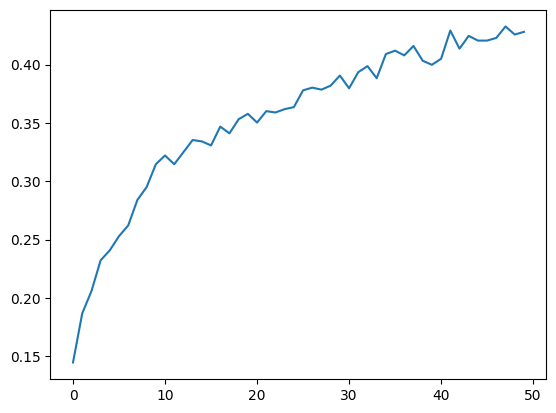

In [ ]:
plt.plot(acc)